In [1]:
import re
import nltk
import pickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
!python -m nltk.downloader stopwords wordnet punkt averaged_perceptron_tagger
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.layers import Attention
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
!pip install rouge
from rouge import Rouge

/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Using TensorFlow backend.


### Hyperparameters

In [0]:
BATCH_SIZE=40 # a batch size greater than 40 tends to cause resource allocation errors
EPOCHS=100
LATENT_DIM=256
EMBEDDING_DIM=128
TEST_TRAIN_SPLIT=0.15
LEARNING_RATE=0.005
PATH=""
FILE_NAME="dailymail.csv"
MAX_TEXT_LEN = 100
MAX_SUMMARY_LEN = 25
UNCOMMON_WORD_THRESHOLD = 15
COLAB=True # true if running on colab
build_number="1"


In [0]:
# create rouge object for evaluation
rouge = Rouge()

## Data Processing

Read In Data

In [4]:
# Only needed if running on Google Colab
if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  PATH = "./drive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
df = pd.read_csv(PATH + FILE_NAME)
print(df.head())

   Unnamed: 0  ...                                            summary
0           0  ...  Sky has been in fierce competition with Frank ...
1           1  ...  Kim Taylor 54 left the device plugged in on ba...
2           2  ...  Nicholas Levene must pay the nominal sum becau...
3           3  ...  Bella RodriguezTorres was diagnosed with stage...
4           4  ...  Japanese chief cabinet secretary Yoshihide Sug...

[5 rows x 4 columns]


In [6]:
print(df.count)

<bound method DataFrame.count of       Unnamed: 0  ...                                            summary
0              0  ...  Sky has been in fierce competition with Frank ...
1              1  ...  Kim Taylor 54 left the device plugged in on ba...
2              2  ...  Nicholas Levene must pay the nominal sum becau...
3              3  ...  Bella RodriguezTorres was diagnosed with stage...
4              4  ...  Japanese chief cabinet secretary Yoshihide Sug...
...          ...  ...                                                ...
4995        4995  ...  Balotelli starts Italys bootcamp an hour after...
4996        4996  ...  Nixon Hunter was premature and has undergone m...
4997        4997  ...  Cook says Pietersens criticism is nothing he h...
4998        4998  ...  Anger towards Aviva follows several other rebu...
4999        4999  ...  Police in Virginia were called to a wooded are...

[5000 rows x 4 columns]>


Remove .'s that appear in stuff like U.S.A and U.N - Eventually need to move this to dataprocessing.py

In [0]:
# print(df['summary'][0])
# df['summary'] = df['summary'].apply(lambda x: re.sub(r'\..*$',' ',str(x)))
# print(df['summary'][0])

In [8]:
print(df['summary'][0])
df['summary'] = df['summary'].apply(lambda x: re.sub(r'\.','',str(x)))
print(df['summary'][0])

Sky has been in fierce competition with Frank Warrens BoxNation The broadcaster has won the right to show the 300m 200m bout Sky has set the price for Floyd Mayweather vs Manny Pacquiao at 19.95 The megafight takes place at the MGM Grand in Las Vegas on May 2 Read how Jeff Powell broke the news of Skys deal 
Sky has been in fierce competition with Frank Warrens BoxNation The broadcaster has won the right to show the 300m 200m bout Sky has set the price for Floyd Mayweather vs Manny Pacquiao at 1995 The megafight takes place at the MGM Grand in Las Vegas on May 2 Read how Jeff Powell broke the news of Skys deal 


Check for rows with null values in them, and copy these into a new dataframe (df1). Drop any rows in df1 from df to ensure no NaN valued rows are present/

*Note. using simply dropna(how='any') does not seem to drop any of the rows*

In [9]:
print(df.isnull().values.any())
print(df.shape)

df1 = df[df.isna().any(axis=1)]
print(df1.shape)

df.drop(df1.index, axis=0,inplace=True)
print(df.shape)
print(df.isnull().values.any())

False
(5000, 4)
(0, 4)
(5000, 4)
False


 Cut down text to MAX_TEXT_LEN words, and summaries to MAX_SUMMARY_LEN

In [10]:
print(df['text'][0])
df['text'] = df['text'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join(x[:MAX_TEXT_LEN]))
print(df['text'][0])

Sky have won the bidding war for the right to screen Floyd Mayweather v Manny Pacquiao in the UK as reveal by Sportsmail last Friday The richest fight of all time will not come cheap either for Sky Sports or their subscriber even though Sky be keep faith with their core follow by keep the base price below 20 It have take what be described by industry insider as a very substantial offer for Sky to fend off fierce competition from Frank Warrens BoxNation Floyd Mayweathers hotlyanticipated bout with Manny Pacquiao will be show on Sky Sports Pacquiao head for the playground after work out in Los Angeles previously The price for the fight have be set at 1995 until midnight of Friday May 1 The cost will remain the same for those pay via remote control or online but will be 2495 if book via phone after Friday Sky be flirt with their threshold of 20 by charge 1995 a buy on their Sports Box Office channel until midnight on May 1 rise to 2495 on May 2 the day of the fight in Las Vegas Since they

In [11]:
print(df['summary'][0])
df['summary'] = df['summary'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join(x[:MAX_SUMMARY_LEN]))
print(df['summary'][0])

Sky has been in fierce competition with Frank Warrens BoxNation The broadcaster has won the right to show the 300m 200m bout Sky has set the price for Floyd Mayweather vs Manny Pacquiao at 1995 The megafight takes place at the MGM Grand in Las Vegas on May 2 Read how Jeff Powell broke the news of Skys deal 
Sky has been in fierce competition with Frank Warrens BoxNation The broadcaster has won the right to show the 300m 200m bout Sky has set


Word Count Distribution

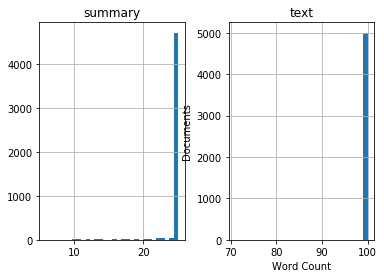

In [12]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['text']:
      text_word_count.append(len(i.split(' ')))

for i in df['summary']:
      summary_word_count.append(len(i.split(' ')))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.ylabel('Documents')
plt.xlabel('Word Count')
# plt.savefig('word_count_distro' + str(build_number) + '.png')
plt.show()

Max Text Lengths

In [13]:
MAX_TEXT_LEN = max([len(txt.split(' ')) for txt in df['text']])
MAX_SUMMARY_LEN = max([len(txt.split(' ')) for txt in df['summary']])
print(MAX_TEXT_LEN)
print(MAX_SUMMARY_LEN)

100
25


### Finding Uncommon Words and Removing Them.

Uncommon words are classified as those that occur in the whole corpus less times than UNCOMMON_WORD_THRESHOLD







#### Text

In [14]:
x_word_dict = {}
text = df['text'].apply(lambda x: nltk.word_tokenize(x))

for index, row in text.iteritems():
  for word in row:
    if word not in x_word_dict.keys():
      x_word_dict[word] = 1
    else:
      x_word_dict[word] += 1

print(len(x_word_dict))
# sort so that extracting acceptable words is more efficient for larger vocab sizes
sorted_dict = sorted(x_word_dict.items(), key=lambda x: x[1], reverse=True)
print(sorted_dict)
x, y = zip(*sorted_dict)

34464
[('the', 22030), ('be', 15339), ('a', 13353), ('to', 12217), ('of', 11556), ('in', 10262), ('and', 8853), ('have', 7205), ('for', 5109), ('on', 5065), ('The', 4201), ('his', 3898), ('with', 3665), ('at', 3358), ('as', 2865), ('that', 2795), ('her', 2738), ('EST', 2732), ('after', 2685), ('from', 2639), ('by', 2637), ('he', 2527), ('By', 2247), ('who', 2156), ('an', 1998), ('their', 1870), ('say', 1836), ('A', 1829), ('2013', 1717), ('it', 1708), ('year', 1411), ('UPDATED', 1390), ('PUBLISHED', 1340), ('she', 1292), ('down', 1255), ('they', 1142), ('which', 1127), ('will', 1116), ('when', 1107), ('up', 1080), ('out', 1072), ('take', 1041), ('but', 1025), ('not', 998), ('2012', 930), ('one', 905), ('video', 902), ('into', 896), ('make', 888), ('this', 874), ('last', 870), ('Scroll', 863), ('over', 827), ('two', 817), ('new', 784), ('its', 777), ('home', 766), ('more', 754), ('than', 748), ('But', 712), ('him', 707), ('show', 696), ('time', 693), ('just', 668), ('go', 659), ('left',

In [15]:
# find words that occur more than UNCOMMON_WORD_THRESHOLD times
accept_words = []
for word, occ in sorted_dict:
  if int(occ) > UNCOMMON_WORD_THRESHOLD:
    accept_words.append(word)
  else:
    break

# remove uncommon words     
accept_words = [x.lower() for x in accept_words]
print(accept_words)
print(df['text'][2])
df['text'] = df['text'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join([word for word in x if word.lower() in accept_words]))
print(df['text'][2])


['the', 'be', 'a', 'to', 'of', 'in', 'and', 'have', 'for', 'on', 'the', 'his', 'with', 'at', 'as', 'that', 'her', 'est', 'after', 'from', 'by', 'he', 'by', 'who', 'an', 'their', 'say', 'a', '2013', 'it', 'year', 'updated', 'published', 'she', 'down', 'they', 'which', 'will', 'when', 'up', 'out', 'take', 'but', 'not', '2012', 'one', 'video', 'into', 'make', 'this', 'last', 'scroll', 'over', 'two', 'new', 'its', 'home', 'more', 'than', 'but', 'him', 'show', 'time', 'just', 'go', 'left', 'about', 'first', 'woman', 'found', 'day', 'man', 'before', 'could', 'use', 'picture', 'police', 'today', 'would', 'now', 'during', 'get', 'come', 'week', 'off', 'month', 'can', 'people', 'while', 'or', 'against', 'told', 'back', 'three', 'it', 'do', 'see', 'give', 'child', 'he', 'new', 'life', 'family', 'former', 'face', 'also', 'call', 'mail', 'most', 'reveal', 'kill', 'them', 'die', 'work', 'night', 'claim', 'all', 'world', 'charge', 'i', 'look', 'because', 'only', 'daily', 'death', 'reporter', 'mother

In [16]:
x_word_dict_after = {}
text = df['text'].apply(lambda x: nltk.word_tokenize(x))

for index, row in text.iteritems():
  for word in row:
    if word not in x_word_dict_after.keys():
      x_word_dict_after[word] = 1
    else:
      x_word_dict_after[word] += 1

print(len(x_word_dict_after))

4643


#### Summaries

In [17]:
y_word_dict = {}
summary = df['summary'].apply(lambda x: nltk.word_tokenize(x))

for index, row in summary.iteritems():
  for word in row:
    if word not in y_word_dict.keys():
      y_word_dict[word] = 1
    else:
      y_word_dict[word] += 1

print(len(y_word_dict))
sorted_dict = sorted(y_word_dict.items(), key=lambda x: x[1], reverse=True)
print(sorted_dict)
x, y = zip(*sorted_dict)

22394
[('the', 3450), ('to', 3042), ('in', 3024), ('of', 2499), ('a', 2187), ('and', 2156), ('was', 1474), ('on', 1374), ('for', 1202), ('The', 1120), ('at', 974), ('is', 943), ('with', 905), ('has', 776), ('his', 733), ('from', 716), ('by', 683), ('her', 594), ('after', 585), ('as', 523), ('he', 511), ('have', 484), ('be', 425), ('He', 423), ('been', 406), ('will', 400), ('are', 392), ('had', 387), ('were', 343), ('that', 313), ('said', 303), ('their', 293), ('she', 292), ('an', 292), ('it', 274), ('out', 265), ('up', 243), ('found', 242), ('over', 239), ('says', 234), ('when', 233), ('last', 232), ('into', 231), ('She', 222), ('years', 214), ('two', 214), ('not', 206), ('home', 205), ('It', 191), ('who', 189), ('than', 185), ('new', 177), ('but', 175), ('one', 175), ('first', 171), ('more', 165), ('year', 165), ('A', 164), ('they', 162), ('But', 160), ('New', 160), ('being', 156), ('him', 152), ('this', 150), ('also', 148), ('could', 143), ('during', 141), ('people', 137), ('They', 1

In [18]:
accept_words = []
for word, occ in sorted_dict:
  if int(occ) > UNCOMMON_WORD_THRESHOLD:
    accept_words.append(word)
  else:
    break
     
accept_words = [x.lower() for x in accept_words]
print(accept_words)
print(df['summary'][2])
df['summary'] = df['summary'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join([word for word in x if word.lower() in accept_words]))
print(df['summary'][2])

['the', 'to', 'in', 'of', 'a', 'and', 'was', 'on', 'for', 'the', 'at', 'is', 'with', 'has', 'his', 'from', 'by', 'her', 'after', 'as', 'he', 'have', 'be', 'he', 'been', 'will', 'are', 'had', 'were', 'that', 'said', 'their', 'she', 'an', 'it', 'out', 'up', 'found', 'over', 'says', 'when', 'last', 'into', 'she', 'years', 'two', 'not', 'home', 'it', 'who', 'than', 'new', 'but', 'one', 'first', 'more', 'year', 'a', 'they', 'but', 'new', 'being', 'him', 'this', 'also', 'could', 'during', 'people', 'they', 'against', 'made', 'three', 'about', 'before', 'can', 'just', 'off', 'manchester', 'which', 'now', 'man', 'london', 'four', 'died', 'told', 'claims', 'police', 'us', 'left', 'police', 'david', 'set', 'say', 'back', 'since', 'while', 'used', 'england', 'its', 'week', 'or', 'time', 'would', 'united', 'former', 'city', 'show', 'down', 'league', 'wife', 'death', 'only', 'per', 'took', 'went', 'mother', '20', 'face', 'uk', 'through', 'called', 'car', '30', 'arrested', 'british', 'five', 'world'

In [19]:
y_word_dict_after = {}
summary = df['summary'].apply(lambda x: nltk.word_tokenize(x))

for index, row in summary.iteritems():
  for word in row:
    if word not in y_word_dict_after.keys():
      y_word_dict_after[word] = 1
    else:
      y_word_dict_after[word] += 1
print(len(y_word_dict_after))

1566


 Max lengths after removal of words

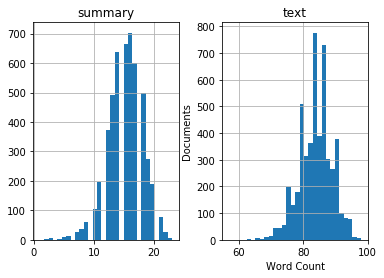

In [20]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['text']:
      text_word_count.append(len(i.split(' ')))

for i in df['summary']:
      summary_word_count.append(len(i.split(' ')))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.ylabel('Documents')
plt.xlabel('Word Count')

# plt.savefig('word_count_distro' + str(build_number) + '.png')
plt.show()

### Update Max Text Lenths After Uncommon Word Removal & Drop Empty Rows

In [21]:
# update max text lengths
MAX_TEXT_LEN = max([len(txt.split(' ')) for txt in df['text']])
MAX_SUMMARY_LEN = max([len(txt.split(' ')) for txt in df['summary']])
print(MAX_TEXT_LEN)
print(MAX_SUMMARY_LEN)

98
23


In [22]:
# drop any lines that have no text or summary after the word removal process
print(df.isnull().values.any())
print(df.shape)

df1 = df[df.isna().any(axis=1)]
print(df1.shape)

df.drop(df1.index, axis=0,inplace=True)
print(df.shape)
print(df.isnull().values.any())

False
(5000, 4)
(0, 4)
(5000, 4)
False


### Training-Validation Split

X - Articles text </br>
Y - Summaries

In [0]:
# convert to numpy array
X = np.array(df['text'])
Y = np.array(df['summary'])

In [24]:
x_tr,x_val,y_tr,y_val=train_test_split(X,Y,test_size=TEST_TRAIN_SPLIT,random_state=0,shuffle=True)
print(x_tr.shape)
print(x_val.shape)
print(y_tr.shape)
print(y_val.shape)

(4250,)
(750,)
(4250,)
(750,)


### Word Embeddings - Tokenization

X Tokenizer

In [25]:
word_dict = {}
text = df['text']

for row in text: 
  for word in row.split(" "):
    if word not in word_dict:
      word_dict[word] = 1
    else:
      word_dict[word] += 1

print(len(word_dict))

4643


In [26]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=len(word_dict), split=" ") 
x_tokenizer.fit_on_texts(list(X))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=MAX_TEXT_LEN, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=MAX_TEXT_LEN, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1
print(x_voc)

4644


In [0]:
# with open('xtokenizer.pickle', 'wb') as handle:
#   pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Y Tokenizer

In [28]:
y_word_dict = {}
summ = df['summary']

for row in summ: 
  for word in row.split(" "):
    if word not in y_word_dict:
      y_word_dict[word] = 1
    else:
      y_word_dict[word] += 1

print(len(y_word_dict))

1567


In [29]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=len(y_word_dict), split=" ") 
y_tokenizer.fit_on_texts(list(Y))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=MAX_SUMMARY_LEN, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=MAX_SUMMARY_LEN, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words + 1
print(y_voc)

1568


In [0]:
# with open('ytokenizer.pickle', 'wb') as handle:
#   pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Learning Model

#### Encoder Model

In [31]:
#encoder input
encoder_inputs = Input(shape=(MAX_TEXT_LEN,))
#embedding layer
enc_emb =  Embedding(x_voc,EMBEDDING_DIM,trainable=True)(encoder_inputs)
# bidirectional encoder lstm 
encoder_lstm = Bidirectional(LSTM(LATENT_DIM,return_sequences=True,return_state=True))
# outputs and encoder final states
encoder_outputs, fw_state_h, fw_state_c, bw_state_h, bw_state_c = encoder_lstm(enc_emb)

state_h = Concatenate()([fw_state_h, bw_state_h])
state_c = Concatenate()([fw_state_c, bw_state_c])
encoder_states = [state_h, state_c]

#### Decoder Model

In [0]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, EMBEDDING_DIM,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(LATENT_DIM*2, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=encoder_states)
                                                          
#dense layer 
#soft max creates a prob vector that allows us to determine the final output
decoder_dense = Dense(y_voc, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


#### Combined LSTM Model

In [33]:
# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 98)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 98, 128)      594432      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 98, 512), (N 788480      embedding_1[0][0]                
____________________________________________________________________________________________

In [0]:
optimizer = RMSprop(lr=LEARNING_RATE, rho=0.9)

In [35]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

- Early Stopping Callback to ensure we stop when Validation Loss is lowest - minimises risk of overfitting
- Model Checkpoint saves the model after each epoch so that we can load the model with the best weights later on. Alternatively, it allows us to continue training the model at a later data



In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2, restore_best_weights=False)
filepath = "./model/saved-model-{epoch:02d}.hdf5"
if COLAB:
  filepath = PATH + "project-model/saved-model-{epoch:02d}.hdf5"
mc = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#### Use this  to train a new model. To continue training a previously trained model see below

In [0]:
# reshape y from two dimensions to three dimensions
y_tr_3d = y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:]
y_val_3d = y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]

In [38]:
print(x_tr.shape)
print(y_tr.shape)
print(y_tr_3d.shape)
print(x_val.shape)
print(y_val.shape)
print(y_val_3d.shape)

(4250, 98)
(4250, 23)
(4250, 22, 1)
(750, 98)
(750, 23)
(750, 22, 1)


In [39]:
history = model.fit([x_tr,y_tr[:,:-1]], y_tr_3d, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[es,mc], 
                    validation_data=([x_val,y_val[:,:-1]], y_val_3d))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 4250 samples, validate on 750 samples
Epoch 1/100





4250/4250 [==============================] - 53s 12ms/step - loss: 4.0553 - val_loss: 3.7684
Epoch 2/100
4250/4250 [==============================] - 43s 10ms/step - loss: 3.5568 - val_loss: 3.5333
Epoch 3/100
4250/4250 [==============================] - 43s 10ms/step - loss: 3.3610 - val_loss: 3.4316
Epoch 4/100
4250/4250 [==============================] - 43s 10ms/step - loss: 3.1916 - val_loss: 3.3787
Epoch 5/100
4250/4250 [==============================] - 42s 10ms/step - loss: 3.0001 - val_loss: 3.4149
Epoch 6/100
4250/4250 [==============================] - 42s 10ms/step - loss: 2.7570 - val_loss: 3.5209
Epoch 00006: early stopping


#### This method is to only be used when loading a previously partially trained model

In [0]:
# model = load_model("./drive/My Drive/project-model/saved-model-53.hdf5")
# history = model.fit([x_tr,y_tr[:,:-1]], y_tr, callbacks=[mc], batch_size=BATCH_SIZE, epochs=1, validation_data=([x_val,y_val[:,:-1]], y_val))

### Plot training and validation loss overtime

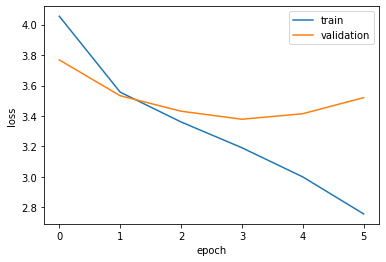

In [41]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
# plt.savefig('loss' + str(build_number) + '.png')
plt.show()

## Inference Model

In [0]:
# load model from drive
# model = load_model("./drive/My Drive/saved-model-53.hdf5")

In [43]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
print(reverse_source_word_index)
print(reverse_target_word_index)

{1: 'the', 2: 'be', 3: 'a', 4: 'to', 5: 'of', 6: 'in', 7: 'and', 8: 'have', 9: 'for', 10: 'on', 11: 'by', 12: 'his', 13: 'with', 14: 'at', 15: 'as', 16: 'he', 17: 'that', 18: 'her', 19: 'after', 20: 'est', 21: 'from', 22: 'an', 23: 'it', 24: 'who', 25: 'their', 26: 'say', 27: 'but', 28: '2013', 29: 'she', 30: 'year', 31: 'updated', 32: 'published', 33: 'they', 34: 'down', 35: 'when', 36: 'new', 37: 'which', 38: 'will', 39: 'this', 40: 'up', 41: 'out', 42: 'one', 43: 'video', 44: 'take', 45: 'not', 46: 'last', 47: '2012', 48: 'two', 49: 'scroll', 50: 'into', 51: 'its', 52: 'make', 53: 'over', 54: 'more', 55: 'home', 56: 'police', 57: 'than', 58: 'show', 59: 'him', 60: 'time', 61: 'just', 62: 'first', 63: 'day', 64: 'now', 65: 'go', 66: 'world', 67: 'about', 68: 'left', 69: 'woman', 70: 'found', 71: 'man', 72: 'today', 73: 'before', 74: 'may', 75: 'while', 76: 'could', 77: 'during', 78: 'use', 79: 'picture', 80: 'would', 81: 'get', 82: 'week', 83: 'come', 84: 'former', 85: 'people', 86: 

In [0]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

In [45]:
encoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 98)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 98, 128)      594432      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 98, 512), (N 788480      embedding_1[0][0]                
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 512)          0           bidirectional_1[0][1]            
                                                                 bidirectional_1[0][3]      

In [0]:
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(LATENT_DIM*2,))
decoder_state_input_c = Input(shape=(LATENT_DIM*2,))
decoder_hidden_state_input = Input(shape=(MAX_TEXT_LEN,LATENT_DIM*2))
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_state_inputs)
decoder_states = [state_h2, state_c2]
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c], [decoder_outputs2] + decoder_states)
# decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs2] + decoder_states)

In [47]:
decoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 128)    200704      input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 512)          0                                            
____________________________________________________________________________________________

### Methods for Reversing Word Embeddings

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

### Summarisation Method 

In [0]:
# Standard Decode Sequence Method - selects most probable word using argmax
def decode_sequence(input_seq): 
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, y_voc))
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
      # Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs2] + decoder_states)
      output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c]) 
      sampled_token_index = np.argmax(output_tokens[0, -1, :][1:])
      # print(output_tokens[0, -1, :].shape) (y_voc, None)
      if (sampled_token_index != 0 ):
        sampled_token = reverse_target_word_index[sampled_token_index]
        decoded_sentence += ' '+sampled_token
      else :
        print("sadface")
        stop_condition = True
      if (len(decoded_sentence.split()) >= (MAX_SUMMARY_LEN-1)):
              stop_condition = True

      # Update the target sequence for next input
      target_seq = np.zeros((1, y_voc))
      target_seq[0, sampled_token_index] = 1

      # Update internal states
      e_h, e_c = h, c
      
    return decoded_sentence

In [0]:
# Decode Sequence - don't allow next token to be the same as the previous token
def decode_sequence2(input_seq): 
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, y_voc))
    # target_seq[0, i] = 1
    # print(target_seq.shape)
    stop_condition = False
    decoded_sentence = ""
    # decoded_sentence = reverse_target_word_index[i]
    last_token = [i]
    while not stop_condition:
      # Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs2] + decoder_states)
      output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c]) 

      # print("ot")
      # print(output_tokens)
      # print("ot[0-1]")
      # print(output_tokens[0, -1, :])
      # print(np.argmax(output_tokens[0, -1, :]))
      # print("out[1:]")
      # print(output_tokens[0, -1, :][1:])
      # print(np.argmax(output_tokens[0, -1, :][1:]))

      sampled_token_index = np.argmax(output_tokens[0, -1, :][1:])
      # prevent it being the same as the last token
      if(sampled_token_index in last_token):
        a = np.delete(output_tokens[0, -1, :][1:], sampled_token_index)
        sampled_token_index=np.argmax(a)
        if sampled_token_index >= last_token[-1] :
          sampled_token_index = sampled_token_index+1 
      # print(sampled_token_index)
      # print(sampled_token_index)
      last_token.append(sampled_token_index)
      if (sampled_token_index != 0 ):
        sampled_token = reverse_target_word_index[sampled_token_index]
        # print(sampled_token)
        decoded_sentence += ' '+sampled_token
      else :
        print("sadface")
        stop_condition = True
      if (len(decoded_sentence.split()) >= (MAX_SUMMARY_LEN-1)):
              stop_condition = True
       # Update the target sequence (of length 1).
      target_seq = np.zeros((1, y_voc))
      target_seq[0, sampled_token_index] = 1
      # print(target_seq)
      # Update internal states
      e_h, e_c = h, c
      
    return decoded_sentence

In [0]:
# Decode Sequence - don't allow next token to be the same as the previous token + feed in first token of orignal summary
def decode_sequence3(input_seq, int): 
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, y_voc))
    target_seq[0, i] = 1
    stop_condition = False
    decoded_sentence = reverse_target_word_index[i]
    last_token = [i]
    while not stop_condition:
      # Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs2] + decoder_states)
      output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c]) 

      # print("ot")
      # print(output_tokens)
      # print("ot[0-1]")
      # print(output_tokens[0, -1, :])
      # print(np.argmax(output_tokens[0, -1, :]))
      # print("out[1:]")
      # print(output_tokens[0, -1, :][1:])
      # print(np.argmax(output_tokens[0, -1, :][1:]))

      # remove first element to always prevent it being zero? could just add one to the count...either way it won't make much difference
      sampled_token_index = np.argmax(output_tokens[0, -1, :][1:])

      # prevent it being the same as the last token
      if(sampled_token_index in last_token):
        a = np.delete(output_tokens[0, -1, :][1:], sampled_token_index)
        sampled_token_index=np.argmax(a)
        if sampled_token_index >= last_token[-1] :
          sampled_token_index = sampled_token_index+1 
      # print(sampled_token_index)

      last_token.append(sampled_token_index)
      if (sampled_token_index != 0 ):
        sampled_token = reverse_target_word_index[sampled_token_index]
        decoded_sentence += ' '+sampled_token
      else :
        print("sadface")
        stop_condition = True
      if (len(decoded_sentence.split()) >= (MAX_SUMMARY_LEN-1)):
              stop_condition = True

      # Update the target sequence.
      target_seq = np.zeros((1, y_voc))
      target_seq[0, sampled_token_index] = 1

      # Update internal states
      e_h, e_c = h, c
      
    return decoded_sentence

## Test Model Output

Note: *I think there isn't enough data being passed in and so the argmax value always is 0 - it can't learn what should be next*

In [0]:
def getRouge(gt, pred):
  return rouge.get_scores(pred, gt)

In [55]:
for i in range(0,3):
    print("----------------------")
    print("Article:",seq2text(x_tr[i]))
    original = seq2summary(y_tr[i])

    if (original !=""):
      # feed the first word of the original summary into the encoder (used for decode_seq3)
      a = nltk.word_tokenize(original)[0]
      for val,word in reverse_target_word_index.items():
        if word == a:
          i = val
      print("Original summary:",original)
      # reshape data into correct format for encoder
      a = x_tr[i].reshape(1,MAX_TEXT_LEN)
      summary2 = decode_sequence2(a)
      summary = decode_sequence(a)
      summary3 = decode_sequence3(a, i)
      print("Generated summary:",summary)
      print("\n")
      print("Generated summary2:",summary2)
      print("\n")
      print("Generated summary3:",summary3)
      print("\n")

      if summary != "":    
        print("ROUGE score: ")
        score = getRouge(str(summary), str(original))
        print(score)
        print(score[0].get('rouge-1').get('f'))
        print(score[0].get('rouge-1').get('p'))
        print(score[0].get('rouge-1').get('r'))
      if summary != "":    
        print("ROUGE score: ")
        score = getRouge(str(summary2), str(original))
        print(score)
        print(score[0].get('rouge-1').get('f'))
        print(score[0].get('rouge-1').get('p'))
        print(score[0].get('rouge-1').get('r'))
      if summary3 != "":    
        print("ROUGE score: ")
        score = getRouge(str(summary3), str(original))
        print(score)
        print(score[0].get('rouge-1').get('f'))
        print(score[0].get('rouge-1').get('p'))
        print(score[0].get('rouge-1').get('r'))

----------------------
Article: by chris pleasance published est 25 february 2014 updated est 25 february 2014 an elderly woman have be reduce to tear after be hand a king which call her and and a the grandmother who would only give her name as say she go to the fast food chain in central virginia on sunday night to buy dinner however she be left horrify and upset after she be hand a with the offensive print at the top offensive an elderly woman and her be hand this at 
Original summary: woman named and bought at when they were their they the their name was 
Generated summary:  by by by by by by by by by by by by by by by by by by by by by by


Generated summary2:  by it have it have it have it have it have it have it have it have it have it have it


Generated summary3: woman by it have it have it have it have it have it have it have it have it have it have


ROUGE score: 
[{'rouge-1': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.0, 'p'

In [54]:
for i in range(1243,1245):
    print("Article:",seq2text(x_tr[i]))
    original = seq2summary(y_tr[i])

    if (original !=""):
      # a = nltk.word_tokenize(original)[0]
      # for val,word in reverse_target_word_index.items():
      #   if word == a:
      #     i = val
      print("Original summary:",original)
      a = x_tr[i].reshape(1,max_text_len)
      summary = decode_sequence(a, i)
      print("Generated summary:",summary)
      print("\n")

      if summary != "":    
        print("ROUGE score: ")
        score = getRouge(str(summary), str(original))
        print(score)
        print(score[0].get('rouge-1').get('f'))
        print(score[0].get('rouge-1').get('p'))
        print(score[0].get('rouge-1').get('r'))

Article: by anna published est 7 february 2013 updated est 8 february 2013 this shock image show the cosmetic damage do to a woman face after 14 year of use the picture show of damage under old kelly hughes feature which can lead to cancer it be take by a skin which show up in detail the extreme damage cause the surface when people lay under the machine experts hope that their campaign will help highlight the danger of to youngster who be often inspire by show 
Original summary: taken by which shows damage in shows face of kelly 30 who has used since she was 


NameError: ignored

In [0]:
print(y_sorted_dict)
print(type(y_sorted_dict))
for x,y in y_sorted_dict:
  if x.lower() == "april":
    print(y)

## Evaluation

Using ROUGE (Recall-Orientated Understanding Gisting Evaluation) to evaluate the generated summaries.

*Note: This takes a long time, especially with large datasets* 

In [0]:
# def get_overlapping_words(x, y):
#   num=0
#   x = nltk.word_tokenize(x)
#   y = nltk.word_tokenize(y)
#   for word in y:
#     if word in x:
#       num = num+1
#       x.remove(word)
#     else:
#       return num

# def precision(target, generated):
#   length = len(target)
#   for i in range (0, length):
#     num_overlapping_words = get_overlapping_words(target[i], generated[i])
#     generated_summary_len = len(generated[i])
#     if generated_summary_len == 0 :
#         return 0.0
#     else : 
#       return num_overlapping_words / generated_summary_len

### For Training Data

In [0]:
# print(len(x_tr))

In [0]:
# tr_target_summary = []
# tr_generated_summary = []
# x_tr_len = len(x_tr)

# f_ov = 0
# p_ov = 0
# r_ov = 0
# # x_val_len = 1
# for i in range(0,x_tr_len):
#   original = seq2summary(y_tr[i])
#   if original != "" :
#     tr_target_summary.append(original)
#     x_i = x_tr[i].reshape(1,max_text_len)
#     summary = decode_sequence(x_i)
#     tr_generated_summary.append(summary)
#     score = getRouge(str(summary), str(original))
#     f_ov += float(score[0].get('rouge-1').get('f'))
#     p_ov += float(score[0].get('rouge-1').get('p'))
#     r_ov += float(score[0].get('rouge-1').get('r'))

In [0]:
# # print("precision : " + str(precision(tr_target_summary, tr_generated_summary)))
# print("Avg F Score: " + str(f_ov/x_tr_len))
# print("Avg Precision: " + str(p_ov/x_tr_len))
# print("Avg Recall: " + str(r_ov/x_tr_len))

### For Validation Data

In [0]:
# val_target_summary = []
# val_generated_summary = []
# x_val_len = len(x_val)
# f_ov = 0
# p_ov = 0
# r_ov = 0

# for i in range(0,x_val_len):
#   original = seq2summary(y_val[i])
#   val_target_summary.append(original)
#   x_i = x_val[i].reshape(1,max_text_len)
#   # summary = decode_sequence(x_i)
#   summary = "new new new new new new new new new"
#   val_generated_summary.append(summary)
#   score = getRouge(str(summary), str(original))
#   f_ov += float(score[0].get('rouge-1').get('f'))
#   p_ov += float(score[0].get('rouge-1').get('p'))
#   r_ov += float(score[0].get('rouge-1').get('r'))

In [0]:
# # print("precision : " + str(precision(val_target_summary, val_generated_summary)))
# print("Avg F Score: " + str(f_ov/x_val_len))
# print("Avg Precision: " + str(p_ov/x_val_len))
# print("Avg Recall: " + str(r_ov/x_val_len))

# Inputting New Data

In [0]:
# def getpos(word):
#   pos = nltk.pos_tag([word])[0][1][0]
#   wordnet_conv = {"J": wn.ADJ, "N": wn.NOUN, "V": wn.VERB, "R": wn.ADV}
#   if pos in wordnet_conv.keys():
#     return wordnet_conv.get(pos)
#   return ""

In [0]:
# def lemmatization(text):
#   lemmatizer = WordNetLemmatizer()
#   text_tokenized = inp_df['text'].apply(lambda x: nltk.word_tokenize(x))
#   print("lemmatize with pos")
#   for i in range(0,len(text_tokenized)):
#     text_lemmatized = []
#     for word in text_tokenized[i]:
#       pos = getpos(word)
#       if pos != "":
#         lemma = lemmatizer.lemmatize(word, pos)
#         text_lemmatized.append(lemma)
#       else :
#         text_lemmatized.append(word)
#     text_lemmatized = ' '.join(map(str, text_lemmatized))
#     inp_df['text'][i] = text_lemmatized


In [0]:
# # input1 = "(CNN) — Earlier this year, Delta Air Lines announced a rethink on reclining seats. In an effort to disrupt fewer passengers' travel experiences, Delta said it'd begin revamping some of its jets to reduce the recline of coach seats from four inches to two inches and the recline of first class seats from 5.5 inches to 3.5 inches. For those who abhor the recline option, it's a small step. And for those who value it, well, it's a compromise. This seemingly innocuous topic is one where there are very much two minds on what's acceptable and what's not. Two CNN Travel staffers engage in a friendly debate about seat recline. Your seat. Your decision. Stacey Lastoe, senior editor at CNN Travel, is of above-average height and makes no apology about reclining; it's her right as a plane, train and bus passenger. She encourages the person sitting in front of her to recline as well. On the first leg of my flight to Japan for my honeymoon, my husband and I got upgraded to first class. Although it would just be a few hours in the sky en route to Dallas, I was excited about sipping Champagne, sitting back and relaxing. Flute in hand, I pushed back to recline my seat for maximum relaxation. But it would not budge; I appeared to be stuck in a dysfunctional seat. Or was I? Turns out the gentleman behind me had a dog in a crate down between his legs, positioned so the seat in front of his -- my seat -- had nowhere to go. Because we were newlyweds and loving every moment of it, I did not mind when my husband turned to the man and told him his wife wanted to recline her seat and asked if he could please rearrange his dog crate to allow for everyones comfort."
# input1 = "Its official US President Barack Obama want lawmaker weigh whether use military force Syria Obama sent letter head House Senate Saturday night hour announce believe military action Syrian target right step take allege use chemical weapon The propose legislation Obama asks Congress approve use military force deter disrupt prevent degrade potential future us chemical weapon weapon mass destruction Its step set turn international crisis fierce domestic political battle There key question loom debate What UN weapon inspector find Syria What happens Congress vote And Syrian government react In televise address White House Rose Garden earlier Saturday president say would take case Congress want While I believe I authority carry military action without specific congressional authorization I know country strong take course action even effective say We debate issue big business usual Obama say top congressional leader agree schedule debate body return Washington September 9 The Senate Foreign Relations Committee hold hearing matter Tuesday Sen Robert Menendez say Transcript Read Obamas full remark Syrian crisis Latest development UN inspector leave Syria Obamas remark come shortly UN inspector left Syria carry evidence determine whether chemical weapon use attack early last week Damascus suburb The aim game mandate clear ascertain whether chemical weapon use UN spokesman Martin Nesirky told reporter Saturday But use weapon report toxic gas attack Damascus suburb August 21 key point global debate Syrian crisis Top US official say there doubt Syrian government behind Syrian official deny responsibility blame jihadist fight rebel British US intelligence report say attack involve chemical weapon UN official stress importance wait official report inspector The inspector share finding UN SecretaryGeneral Ban Kimoon Ban say want wait UN team final report complete present UN Security Council The Organization Prohibition Chemical Weapons nine inspector belong say Saturday could take three week analyze evidence collect It need time able analyze information sample Nesirky say He note Ban repeatedly say alternative political solution crisis Syria military solution option Bergen Syria problem hell US Obama This menace must confront Obamas senior adviser debate next step take president comment Saturday come amid mount political pressure situation Syria Some US lawmaker call immediate action others warn step could become quagmire Some global leader express support British Parliaments vote military action earlier week blow Obamas hope get strong backing key NATO ally On Saturday Obama propose say would limited military action Syrian President Bashar alAssad Any military attack would openended include US ground force say Syrias allege use chemical weapon earlier month assault human dignity president say A failure respond force Obama argue could lead escalate use chemical weapon proliferation terrorist group would people harm In world many danger menace must confront Syria missile strike What would happen next Map US allied asset around Syria Obama decision come Friday night On Friday night president make lastminute decision consult lawmaker What happen vote Its unclear A senior administration official told CNN Obama authority act without Congress even Congress reject request authorization use force Obama Saturday continued shore support strike alAssad government He spoke phone French President Francois Hollande Rose Garden speech The two leader agree international community must deliver resolute message Assad regime others would consider use chemical weapon crime unacceptable violate international norm held accountable world White House say Meanwhile uncertainty loom Congress would weigh US military official say remain ready 5 key assertion US intelligence report Syria Syria Who want chemical weapon horror Reactions mixed Obamas speech A spokesman Syrian National Coalition say opposition group disappointed Obamas announcement Our fear lack action could embolden regime repeat attack serious way say spokesman Louay Safi So quite concerned Some member Congress applaud Obamas decision House Speaker John Boehner Majority Leader Eric Cantor Majority Whip Kevin McCarthy Conference Chair Cathy McMorris Rodgers issue statement Saturday praise president Under Constitution responsibility declare war lie Congress Republican lawmaker say We glad president seek authorization military action Syria response serious substantive question raise More 160 legislator include 63 Obamas fellow Democrats sign letter call either vote least full debate US action British Prime Minister David Cameron whose attempt get lawmaker country support military action Syria fail earlier week respond Obamas speech Twitter post Saturday I understand support Barack Obamas position Syria Cameron say An influential lawmaker Russia stood Syria criticize United States theory The main reason Obama turn Congress military operation get enough support either world among ally US United States Alexei Pushkov chairman internationalaffairs committee Russian State Duma say Twitter post In United States scatter group antiwar protester around country take street Saturday Like many Americanswere tire United States get involve invade bombing country say Robin Rosecrans among hundred Los Angeles demonstration What Syrias neighbor think Why Russia China Iran stand Assad Syrias government unfazed After Obamas speech military political analyst Syrian state TV say Obama embarrass Russia opposes military action Syria cry help someone come rescue face two defeat political military level Syrias prime minister appear unfazed saberrattling The Syrian Armys status maximum readiness finger trigger confront challenge Wael Nader alHalqi say meeting delegation Syrian expatriate Italy accord banner Syria State TV broadcast prior Obamas address An anchor Syrian state television say Obama appear prepare aggression Syria base repeat lie A top Syrian diplomat told state television network Obama face pressure take military action Israel Turkey Arabs rightwing extremist United States I think do well Cameron term take issue Parliament say Bashar Jaafari Syrias ambassador United Nations Both Obama Cameron say climbed top tree dont know get The Syrian government deny use chemical weapon August 21 attack say jihadist fight rebel use effort turn global sentiment British intelligence put number people kill attack 350 On Saturday Obama say told well 1000 people murder US Secretary State John Kerry Friday cite death toll 1429 400 child No explanation offer discrepancy Iran US military action Syria would spark disaster Opinion Why strike Syria bad idea"
# inp_df = pd.DataFrame(columns=['text', 'summary'])
# inp_df = inp_df.append({'text': str(input1), 'summary': ""}, ignore_index=True)
# inp_df.head()

In [0]:
# inp_df['text'] = inp_df['text'].apply(lambda x: re.sub(r'\(CNN\)|--|[^\w\s\.]','',x)).apply(lambda x: re.sub(r'(\.(?=[\s\r\n]|$))','',x)).apply(lambda x: re.sub(r'\n',' ',x)).apply(lambda x: re.sub(r'\.','',x))

In [0]:
# # remove stop words
# stop_words = set(stopwords.words('english'))
# inp_df['text'] = inp_df['text'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join([word for word in x if not word in stop_words]))

In [0]:
# #lemmatize
# lemmatization(inp_df['text'])
# print(inp_df['text'])

In [0]:
# seq = np.array(inp_df['text'])
# print(seq)

In [0]:
# seq_tokenizer = x_tokenizer.texts_to_sequences(seq)
# #padding zero upto maximum length
# seq_tokenizer_padded = pad_sequences(seq_tokenizer,  maxlen=max_text_len, padding='post')

# gen_summary = decode_sequence(seq_tokenizer_padded)

# original_txt = ' '.join(seq)

# print("---")
# print("Original: " + original_txt)
# print("Generated Summary: " + gen_summary)
# print("ROUGE score: ")
# print(getRouge(summary, original_txt))